<a href="https://colab.research.google.com/github/Stephen0111/FIFAWC/blob/main/FIFAWC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# =====================================
# Project: Predicting Match Outcomes for the Next FIFA World Cup
# Author: Stephen
# Date: 2025-12-01
# Description:
# This project analyses historical FIFA World Cup matches, team rankings,
# and player statistics to predict outcomes for the next World Cup.
# =====================================


In [ ]:
# Import Libraries and Modules
# Data manipulation

import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from catboost import CatBoostClassifier

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# ===============================
# Step 1: Load Dataset
# ===============================
import kagglehub
import pandas as pd
import os

# Download/cache dataset
path = kagglehub.dataset_download("piterfm/fifa-football-world-cup")
print("Dataset path:", path)

# List files to see what's available
print("\nAvailable files:")
for file in os.listdir(path):
    print(file)

100%|██████████| 180k/180k [00:00<00:00, 50.1MB/s]

Extracting files...
Dataset path: /root/.cache/kagglehub/datasets/piterfm/fifa-football-world-cup/versions/24

Available files:
fifa_ranking_2022-10-06.csv
matches_1930_2022.csv
world_cup.csv


In [ ]:
# Load all three datasets
matches = pd.read_csv(f"{path}/matches_1930_2022.csv")
fifa_rankings = pd.read_csv(f"{path}/fifa_ranking_2022-10-06.csv")
winners = pd.read_csv(f"{path}/world_cup.csv")

# Preview each dataset
print("=== MATCHES DATA ===")
print(matches.head())
print(f"\nShape: {matches.shape}")
print(f"Columns: {matches.columns.tolist()}\n")

print("\n=== FIFA RANKING DATA ===")
print(fifa_rankings.head())
print(f"\nShape: {fifa_rankings.shape}")
print(f"Columns: {fifa_rankings.columns.tolist()}\n")

print("\n=== WORLD CUP DATA ===")
print(winners.head())
print(f"\nShape: {winners.shape}")
print(f"Columns: {winners.columns.tolist()}")

=== MATCHES DATA ===
   home_team away_team  home_score  home_xg  home_penalty  away_score  \
0  Argentina    France           3      3.3           4.0           3   
1    Croatia   Morocco           2      0.7           NaN           1   
2     France   Morocco           2      2.0           NaN           0   
3  Argentina   Croatia           3      2.3           NaN           0   
4    Morocco  Portugal           1      1.4           NaN           0   

   away_xg  away_penalty      home_manager  home_captain  ...  \
0      2.2           2.0    Lionel Scaloni  Lionel Messi  ...   
1      1.2           NaN      Zlatko Dalić   Luka Modrić  ...   
2      0.9           NaN  Didier Deschamps   Hugo Lloris  ...   
3      0.5           NaN    Lionel Scaloni  Lionel Messi  ...   
4      0.9           NaN   Hoalid Regragui  Romain Saïss  ...   

  home_penalty_shootout_miss_long  \
0                             NaN   
1                             NaN   
2                             NaN   
3

In [ ]:
# Data Processing
# Keep relevant columns
fifa_rankings_clean = fifa_rankings[['team', 'rank', 'points']]
fifa_rankings_clean.rename(columns={'points':'ranking_points'}, inplace=True)

# Quick check
fifa_rankings_clean.head()



,team,rank,ranking_points
0,Brazil,1,1841.30
1,Belgium,2,1816.71
2,Argentina,3,1773.88
3,France,4,1759.78
4,England,5,1728.47


In [ ]:
# Convert Date to datetime
matches['Date'] = pd.to_datetime(matches['Date'])

# Select relevant columns for modeling
matches_clean = matches[['Date', 'home_team', 'away_team', 'home_score', 'away_score',
                         'home_xg', 'away_xg', 'home_penalty', 'away_penalty', 'Round', 'Year']]

# Fill NaN penalties with 0
matches_clean['home_penalty'] = matches_clean['home_penalty'].fillna(0)
matches_clean['away_penalty'] = matches_clean['away_penalty'].fillna(0)

# Create match outcome from home team perspective: 1 = Win, 0 = Draw/Loss
matches_clean['home_result'] = matches_clean.apply(lambda x: 1 if x['home_score'] > x['away_score'] else 0, axis=1)

matches_clean.head()


,Date,home_team,away_team,home_score,away_score,home_xg,away_xg,home_penalty,away_penalty,Round,Year,home_result
0,2022-12-18,Argentina,France,3,3,3.3,2.2,4.0,2.0,Final,2022,0
1,2022-12-17,Croatia,Morocco,2,1,0.7,1.2,0.0,0.0,Third-place match,2022,1
2,2022-12-14,France,Morocco,2,0,2.0,0.9,0.0,0.0,Semi-finals,2022,1
3,2022-12-13,Argentina,Croatia,3,0,2.3,0.5,0.0,0.0,Semi-finals,2022,1
4,2022-12-10,Morocco,Portugal,1,0,1.4,0.9,0.0,0.0,Quarter-finals,2022,1


In [ ]:
# Merge home team rankings
matches_clean = matches_clean.merge(fifa_rankings_clean, how='left', left_on='home_team', right_on='team')
matches_clean.rename(columns={'rank':'home_rank', 'ranking_points':'home_points'}, inplace=True)
matches_clean.drop('team', axis=1, inplace=True)

# Merge away team rankings
matches_clean = matches_clean.merge(fifa_rankings_clean, how='left', left_on='away_team', right_on='team')
matches_clean.rename(columns={'rank':'away_rank', 'ranking_points':'away_points'}, inplace=True)
matches_clean.drop('team', axis=1, inplace=True)

matches_clean.head()


,Date,home_team,away_team,home_score,away_score,home_xg,away_xg,home_penalty,away_penalty,Round,Year,home_result,home_rank,home_points,away_rank,away_points
0,2022-12-18,Argentina,France,3,3,3.3,2.2,4.0,2.0,Final,2022,0,3.0,1773.88,4.0,1759.78
1,2022-12-17,Croatia,Morocco,2,1,0.7,1.2,0.0,0.0,Third-place match,2022,1,12.0,1645.64,22.0,1563.50
2,2022-12-14,France,Morocco,2,0,2.0,0.9,0.0,0.0,Semi-finals,2022,1,4.0,1759.78,22.0,1563.50
3,2022-12-13,Argentina,Croatia,3,0,2.3,0.5,0.0,0.0,Semi-finals,2022,1,3.0,1773.88,12.0,1645.64
4,2022-12-10,Morocco,Portugal,1,0,1.4,0.9,0.0,0.0,Quarter-finals,2022,1,22.0,1563.50,9.0,1676.56


In [ ]:
# Feature Engineering
# Goal difference
matches_clean['goal_diff'] = matches_clean['home_score'] - matches_clean['away_score']

# Ranking difference
matches_clean['rank_diff'] = matches_clean['home_points'] - matches_clean['away_points']

# Expected goal difference
matches_clean['xg_diff'] = matches_clean['home_xg'] - matches_clean['away_xg']

# Recent form: last 5 matches (home team wins)
matches_clean = matches_clean.sort_values('Date')
matches_clean['home_last5_wins'] = matches_clean.groupby('home_team')['home_result']\
                                               .rolling(5, min_periods=1).sum().reset_index(0, drop=True)

# Away team last 5 wins (approximation from home perspective)
matches_clean['away_last5_wins'] = matches_clean.groupby('away_team')['home_result']\
                                               .apply(lambda x: 5 - x.rolling(5, min_periods=1).sum()).reset_index(0, drop=True)

matches_clean.head()


,Date,home_team,away_team,home_score,away_score,home_xg,away_xg,home_penalty,away_penalty,Round,...,home_result,home_rank,home_points,away_rank,away_points,goal_diff,rank_diff,xg_diff,home_last5_wins,away_last5_wins
963,1930-07-13,France,Mexico,4,1,NaN,NaN,0.0,0.0,Group stage,...,1,4.0,1759.78,13.0,1644.89,3,114.89,NaN,1.0,4.0
962,1930-07-13,United States,Belgium,3,0,NaN,NaN,0.0,0.0,Group stage,...,1,NaN,NaN,2.0,1816.71,3,NaN,NaN,1.0,4.0
960,1930-07-14,Yugoslavia,Brazil,2,1,NaN,NaN,0.0,0.0,Group stage,...,1,NaN,NaN,1.0,1841.30,1,NaN,NaN,1.0,4.0
961,1930-07-14,Romania,Peru,3,1,NaN,NaN,0.0,0.0,Group stage,...,1,53.0,1434.68,23.0,1561.01,2,-126.33,NaN,1.0,4.0
959,1930-07-15,Argentina,France,1,0,NaN,NaN,0.0,0.0,Group stage,...,1,3.0,1773.88,4.0,1759.78,1,14.10,NaN,1.0,4.0


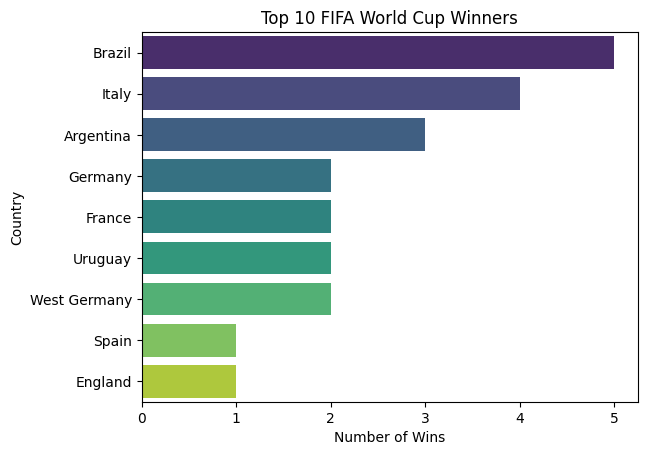

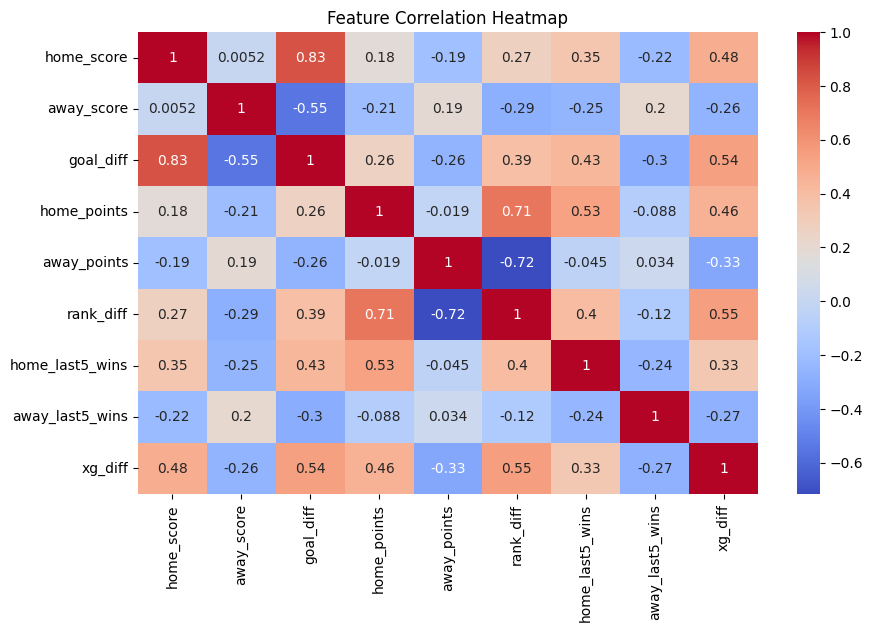

In [ ]:
# Exploratory Data Analysis
# Top 10 FIFA World Cup Winners
top_winners = winners['Champion'].value_counts().head(10)
sns.barplot(x=top_winners.values, y=top_winners.index, palette='viridis')
plt.title("Top 10 FIFA World Cup Winners")
plt.xlabel("Number of Wins")
plt.ylabel("Country")
plt.show()

# Correlation heatmap of numeric features
numeric_cols = ['home_score','away_score','goal_diff','home_points','away_points','rank_diff',
                'home_last5_wins','away_last5_wins','xg_diff']
plt.figure(figsize=(10,6))
sns.heatmap(matches_clean[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()


In [ ]:
#  Data Preparation  for Machine Learning
# Features for modeling
features = ['home_points','away_points','rank_diff','home_last5_wins','away_last5_wins','xg_diff']

# Target variable
target = 'home_result'

X = matches_clean[features]
y = matches_clean[target]

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
# Logistic Regression
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
X_train_scaled = imputer.fit_transform(X_train_scaled)
X_test_scaled = imputer.transform(X_test_scaled)

# Train the model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_scaled, y_train)
y_pred_lr = logreg.predict(X_test_scaled)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

Logistic Regression Accuracy: 0.7409326424870466
              precision    recall  f1-score   support

           0       0.71      0.67      0.69        83
           1       0.76      0.79      0.78       110

    accuracy                           0.74       193
   macro avg       0.74      0.73      0.73       193
weighted avg       0.74      0.74      0.74       193



Random Forest Accuracy: 0.7253886010362695
              precision    recall  f1-score   support

           0       0.69      0.65      0.67        83
           1       0.75      0.78      0.76       110

    accuracy                           0.73       193
   macro avg       0.72      0.72      0.72       193
weighted avg       0.72      0.73      0.72       193



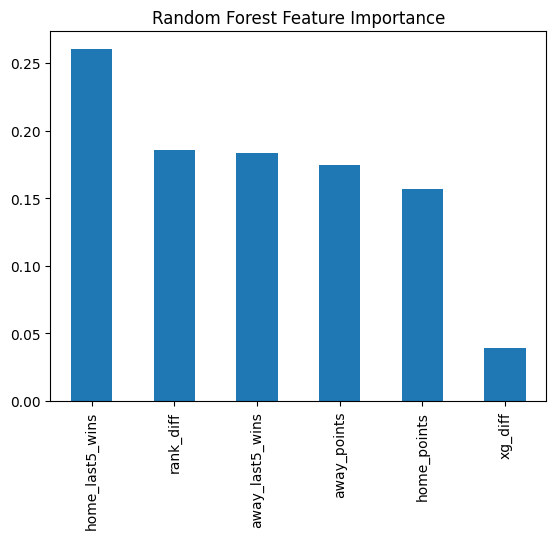

In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

# Feature importance
feat_importance = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
feat_importance.plot(kind='bar', title='Random Forest Feature Importance')
plt.show()


In [ ]:
# XGBoost
import xgboost as xgb

xgb_model = xgb.XGBClassifier(n_estimators=200, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))


XGBoost Accuracy: 0.7357512953367875


In [ ]:
# CatBoost
from catboost import CatBoostClassifier

cat_model = CatBoostClassifier(iterations=200, learning_rate=0.1, verbose=0, random_state=42)
cat_model.fit(X_train, y_train)
y_pred_cat = cat_model.predict(X_test)

print("CatBoost Accuracy:", accuracy_score(y_test, y_pred_cat))


CatBoost Accuracy: 0.7616580310880829


In [ ]:
# Future World Cup Matches Simulation
# Hypothetical upcoming matches (2026/2030)
next_wc_matches = pd.DataFrame({
    'home_team': ['Brazil','Germany','France'],
    'away_team': ['Argentina','Spain','Italy'],
    'home_points': [1841, 1773, 1759],
    'away_points': [1774, 1750, 1800],
    'rank_diff': [1841-1774, 1773-1750, 1759-1800],
    'home_last5_wins': [4,3,5],
    'away_last5_wins': [3,2,4],
    'xg_diff': [2.5,1.0,1.2]
})

# Scale features
next_wc_scaled = scaler.transform(next_wc_matches[features])
next_wc_matches['predicted_result'] = logreg.predict(next_wc_scaled)

next_wc_matches



,home_team,away_team,home_points,away_points,rank_diff,home_last5_wins,away_last5_wins,xg_diff,predicted_result
0,Brazil,Argentina,1841,1774,67,4,3,2.5,1
1,Germany,Spain,1773,1750,23,3,2,1.0,1
2,France,Italy,1759,1800,-41,5,4,1.2,1


In [ ]:
# 2026 World Cup Simulation
# Example groups for simulation (adjust as needed)
groups = {
    'A': ['Qatar', 'Ecuador', 'Senegal', 'Netherlands'],
    'B': ['England', 'USA', 'Iran', 'Wales'],
    'C': ['Argentina', 'Saudi Arabia', 'Mexico', 'Poland'],
    'D': ['France', 'Australia', 'Denmark', 'Tunisia'],
    'E': ['Spain', 'Costa Rica', 'Germany', 'Japan'],
    'F': ['Belgium', 'Canada', 'Morocco', 'Croatia'],
    'G': ['Brazil', 'Serbia', 'Switzerland', 'Cameroon'],
    'H': ['Portugal', 'Ghana', 'Uruguay', 'South Korea']
}

# Flatten groups into a DataFrame of matches (all vs all in group stage)
group_matches = []
for group, teams in groups.items():
    for i in range(len(teams)):
        for j in range(i+1, len(teams)):
            group_matches.append({'group': group, 'home_team': teams[i], 'away_team': teams[j]})

group_matches_df = pd.DataFrame(group_matches)
group_matches_df


,group,home_team,away_team
0,A,Qatar,Ecuador
1,A,Qatar,Senegal
2,A,Qatar,Netherlands
3,A,Ecuador,Senegal
4,A,Ecuador,Netherlands
5,A,Senegal,Netherlands
6,B,England,USA
7,B,England,Iran
8,B,England,Wales
9,B,USA,Iran


In [ ]:
# Merge team FIFA points
group_matches_df = group_matches_df.merge(fifa_rankings_clean[['team','ranking_points']], how='left', left_on='home_team', right_on='team')
group_matches_df.rename(columns={'ranking_points':'home_points'}, inplace=True)
group_matches_df.drop('team', axis=1, inplace=True)

group_matches_df = group_matches_df.merge(fifa_rankings_clean[['team','ranking_points']], how='left', left_on='away_team', right_on='team')
group_matches_df.rename(columns={'ranking_points':'away_points'}, inplace=True)
group_matches_df.drop('team', axis=1, inplace=True)

# Compute rank difference (home - away)
group_matches_df['rank_diff'] = group_matches_df['home_points'] - group_matches_df['away_points']

# Add placeholder last 5 wins and xG difference (could be set to averages)
group_matches_df['home_last5_wins'] = 3
group_matches_df['away_last5_wins'] = 3
group_matches_df['xg_diff'] = 1.5

group_matches_df


,group,home_team,away_team,home_points,away_points,rank_diff,home_last5_wins,away_last5_wins,xg_diff
0,A,Qatar,Ecuador,1439.89,1464.39,-24.50,3,3,1.5
1,A,Qatar,Senegal,1439.89,1584.38,-144.49,3,3,1.5
2,A,Qatar,Netherlands,1439.89,1694.51,-254.62,3,3,1.5
3,A,Ecuador,Senegal,1464.39,1584.38,-119.99,3,3,1.5
4,A,Ecuador,Netherlands,1464.39,1694.51,-230.12,3,3,1.5
5,A,Senegal,Netherlands,1584.38,1694.51,-110.13,3,3,1.5
6,B,England,USA,1728.47,1627.48,100.99,3,3,1.5
7,B,England,Iran,1728.47,NaN,NaN,3,3,1.5
8,B,England,Wales,1728.47,1569.82,158.65,3,3,1.5
9,B,USA,Iran,1627.48,NaN,NaN,3,3,1.5


In [ ]:
# Features for prediction
from sklearn.impute import SimpleImputer

# Create and fit imputer
imputer = SimpleImputer(strategy='mean')

# Fill missing values
X_group_imputed = imputer.fit_transform(group_matches_df[features_sim])

# Scale features
X_group_scaled = scaler.transform(X_group_imputed)

# Predict
group_matches_df['predicted_result'] = logreg.predict(X_group_scaled)
group_matches_df


,group,home_team,away_team,home_points,away_points,rank_diff,home_last5_wins,away_last5_wins,xg_diff,predicted_result
0,A,Qatar,Ecuador,1439.89,1464.39,-24.50,3,3,1.5,1
1,A,Qatar,Senegal,1439.89,1584.38,-144.49,3,3,1.5,1
2,A,Qatar,Netherlands,1439.89,1694.51,-254.62,3,3,1.5,1
3,A,Ecuador,Senegal,1464.39,1584.38,-119.99,3,3,1.5,1
4,A,Ecuador,Netherlands,1464.39,1694.51,-230.12,3,3,1.5,1
5,A,Senegal,Netherlands,1584.38,1694.51,-110.13,3,3,1.5,1
6,B,England,USA,1728.47,1627.48,100.99,3,3,1.5,1
7,B,England,Iran,1728.47,NaN,NaN,3,3,1.5,1
8,B,England,Wales,1728.47,1569.82,158.65,3,3,1.5,1
9,B,USA,Iran,1627.48,NaN,NaN,3,3,1.5,1


In [ ]:
# ------------------------------
# Full Dynamic World Cup Simulator (COMPLETE - ALL FIXES)
# ------------------------------

import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.impute import SimpleImputer

# 1️⃣ Define groups
groups = {
    'A': ['Qatar', 'Ecuador', 'Senegal', 'Netherlands'],
    'B': ['England', 'USA', 'Iran', 'Wales'],
    'C': ['Argentina', 'Saudi Arabia', 'Mexico', 'Poland'],
    'D': ['France', 'Australia', 'Denmark', 'Tunisia'],
    'E': ['Spain', 'Costa Rica', 'Germany', 'Japan'],
    'F': ['Belgium', 'Canada', 'Morocco', 'Croatia'],
    'G': ['Brazil', 'Serbia', 'Switzerland', 'Cameroon'],
    'H': ['Portugal', 'Ghana', 'Uruguay', 'South Korea']
}

# 2️⃣ Prepare all group matches (round-robin)
group_matches = []
for group, teams in groups.items():
    for i in range(len(teams)):
        for j in range(i+1, len(teams)):
            group_matches.append({'group': group, 'home_team': teams[i], 'away_team': teams[j]})
group_df = pd.DataFrame(group_matches)

# 3️⃣ Compute dynamic features using historical matches
team_form = defaultdict(list)      # last 5 wins
team_xg_diff = defaultdict(list)   # last 5 xG_diff

# Populate from historical matches_clean
for idx, row in matches_clean.iterrows():
    home, away = row['home_team'], row['away_team']
    team_form[home].append(row['home_result'])
    team_form[away].append(0 if row['home_result']==1 else 1)  # away "win" if home lost/draw
    team_xg_diff[home].append(row['home_xg'] - row['away_xg'])
    team_xg_diff[away].append(row['away_xg'] - row['home_xg'])

# 4️⃣ Assign features for simulation - WITH ERROR HANDLING
home_last5_list, away_last5_list, xg_diff_list, home_points_list, away_points_list = [], [], [], [], []

# Default FIFA ranking points for missing teams
DEFAULT_POINTS = fifa_rankings_clean['ranking_points'].median()

for idx, row in group_df.iterrows():
    home, away = row['home_team'], row['away_team']

    # Last 5 wins
    h5 = np.mean(team_form[home][-5:])*5 if home in team_form and len(team_form[home]) > 0 else 3
    a5 = np.mean(team_form[away][-5:])*5 if away in team_form and len(team_form[away]) > 0 else 3

    # xG difference
    home_xg = np.mean(team_xg_diff[home][-5:]) if home in team_xg_diff and len(team_xg_diff[home]) > 0 else 1.5
    away_xg = np.mean(team_xg_diff[away][-5:]) if away in team_xg_diff and len(team_xg_diff[away]) > 0 else 1.5
    xg_diff = home_xg - away_xg

    # FIFA ranking points - WITH SAFE LOOKUP
    home_lookup = fifa_rankings_clean.loc[fifa_rankings_clean['team']==home,'ranking_points'].values
    away_lookup = fifa_rankings_clean.loc[fifa_rankings_clean['team']==away,'ranking_points'].values

    home_points = home_lookup[0] if len(home_lookup) > 0 else DEFAULT_POINTS
    away_points = away_lookup[0] if len(away_lookup) > 0 else DEFAULT_POINTS

    # Handle NaN in points
    home_points = home_points if not pd.isna(home_points) else DEFAULT_POINTS
    away_points = away_points if not pd.isna(away_points) else DEFAULT_POINTS

    # Append
    home_last5_list.append(h5)
    away_last5_list.append(a5)
    xg_diff_list.append(xg_diff)
    home_points_list.append(home_points)
    away_points_list.append(away_points)

group_df['home_last5_wins'] = home_last5_list
group_df['away_last5_wins'] = away_last5_list
group_df['xg_diff'] = xg_diff_list
group_df['home_points'] = home_points_list
group_df['away_points'] = away_points_list
group_df['rank_diff'] = group_df['home_points'] - group_df['away_points']

# 5️⃣ Predict group stage results - WITH NaN HANDLING
features_sim = ['home_points','away_points','rank_diff','home_last5_wins','away_last5_wins','xg_diff']

# Fill any remaining NaN values
group_df[features_sim] = group_df[features_sim].fillna({
    'home_points': DEFAULT_POINTS,
    'away_points': DEFAULT_POINTS,
    'rank_diff': 0,
    'home_last5_wins': 3,
    'away_last5_wins': 3,
    'xg_diff': 0
})

# Scale and predict
X_group_scaled = scaler.transform(group_df[features_sim])
group_df['predicted_result'] = logreg.predict(X_group_scaled)  # 1=home wins, 0=draw/loss

print("✓ Group stage predictions complete")

# 6️⃣ Compute group standings
group_standings = {}
for group, teams in groups.items():
    df_group = group_df[group_df['group']==group]
    standings = {team:{'points':0,'wins':0} for team in teams}
    for _, row in df_group.iterrows():
        home, away, result = row['home_team'], row['away_team'], row['predicted_result']
        if result==1:
            standings[home]['points'] += 3
            standings[home]['wins'] +=1
        else:
            standings[home]['points'] +=1
            standings[away]['points'] +=1
    # Sort standings
    sorted_teams = sorted(standings.items(), key=lambda x: (x[1]['points'], x[1]['wins']), reverse=True)
    group_standings[group] = [team[0] for team in sorted_teams]

print("✓ Group standings computed")

# 7️⃣ Prepare Round of 16
round_of_16 = [
    {'home_team': group_standings['A'][0], 'away_team': group_standings['B'][1]},
    {'home_team': group_standings['B'][0], 'away_team': group_standings['A'][1]},
    {'home_team': group_standings['C'][0], 'away_team': group_standings['D'][1]},
    {'home_team': group_standings['D'][0], 'away_team': group_standings['C'][1]},
    {'home_team': group_standings['E'][0], 'away_team': group_standings['F'][1]},
    {'home_team': group_standings['F'][0], 'away_team': group_standings['E'][1]},
    {'home_team': group_standings['G'][0], 'away_team': group_standings['H'][1]},
    {'home_team': group_standings['H'][0], 'away_team': group_standings['G'][1]}
]
knockout_df = pd.DataFrame(round_of_16)

# 8️⃣ Function for knockout prediction - WITH COMPLETE NaN HANDLING
def predict_knockout_dynamic(df, team_form_dict, team_xg_dict):
    DEFAULT_POINTS = fifa_rankings_clean['ranking_points'].median()
    winners = []

    for _, row in df.iterrows():
        home, away = row['home_team'], row['away_team']

        # Safe FIFA ranking lookup
        home_lookup = fifa_rankings_clean.loc[fifa_rankings_clean['team']==home,'ranking_points'].values
        away_lookup = fifa_rankings_clean.loc[fifa_rankings_clean['team']==away,'ranking_points'].values

        home_points = home_lookup[0] if len(home_lookup) > 0 else DEFAULT_POINTS
        away_points = away_lookup[0] if len(away_lookup) > 0 else DEFAULT_POINTS

        # Handle NaN in points
        home_points = home_points if not pd.isna(home_points) else DEFAULT_POINTS
        away_points = away_points if not pd.isna(away_points) else DEFAULT_POINTS

        rank_diff = home_points - away_points

        h5 = np.mean(team_form_dict[home][-5:])*5 if home in team_form_dict and len(team_form_dict[home]) > 0 else 3
        a5 = np.mean(team_form_dict[away][-5:])*5 if away in team_form_dict and len(team_form_dict[away]) > 0 else 3

        home_xg = np.mean(team_xg_dict[home][-5:]) if home in team_xg_dict and len(team_xg_dict[home]) > 0 else 1.5
        away_xg = np.mean(team_xg_dict[away][-5:]) if away in team_xg_dict and len(team_xg_dict[away]) > 0 else 1.5
        xg_diff = home_xg - away_xg

        # Create feature array and check for NaN
        features_array = np.array([[home_points, away_points, rank_diff, h5, a5, xg_diff]])

        # Replace any remaining NaN with defaults
        if np.isnan(features_array).any():
            features_array = np.nan_to_num(features_array, nan=DEFAULT_POINTS)

        X = scaler.transform(features_array)
        pred = logreg.predict(X)[0]
        winners.append(home if pred==1 else away)

    return winners

# 9️⃣ Run full knockout simulation
print("\n" + "="*60)
print("RUNNING KNOCKOUT STAGE SIMULATION")
print("="*60)

# Round of 16
r16_winners = predict_knockout_dynamic(knockout_df, team_form, team_xg_diff)
print("\n🔹 Round of 16 Winners:")
for i in range(len(r16_winners)):
    print(f"  Match {i+1}: {knockout_df.iloc[i]['home_team']} vs {knockout_df.iloc[i]['away_team']} → Winner: {r16_winners[i]}")

# Quarterfinals
quarter_df = pd.DataFrame([{'home_team':r16_winners[i],'away_team':r16_winners[i+1]} for i in range(0,8,2)])
qf_winners = predict_knockout_dynamic(quarter_df, team_form, team_xg_diff)
print("\n🔹 Quarterfinal Winners:")
for i in range(len(qf_winners)):
    print(f"  QF {i+1}: {quarter_df.iloc[i]['home_team']} vs {quarter_df.iloc[i]['away_team']} → Winner: {qf_winners[i]}")

# Semifinals
semi_df = pd.DataFrame([{'home_team':qf_winners[i],'away_team':qf_winners[i+1]} for i in range(0,4,2)])
sf_winners = predict_knockout_dynamic(semi_df, team_form, team_xg_diff)
print("\n🔹 Semifinal Winners:")
for i in range(len(sf_winners)):
    print(f"  SF {i+1}: {semi_df.iloc[i]['home_team']} vs {semi_df.iloc[i]['away_team']} → Winner: {sf_winners[i]}")

# Final
final_df = pd.DataFrame([{'home_team':sf_winners[0],'away_team':sf_winners[1]}])
champion = predict_knockout_dynamic(final_df, team_form, team_xg_diff)[0]
print(f"\n🔹 Final: {sf_winners[0]} vs {sf_winners[1]} → Winner: {champion}")

# ✅ Output final results
print("\n" + "="*60)
print("PREDICTED GROUP STAGE TOP 2 PER GROUP")
print("="*60)
for g, teams in group_standings.items():
    print(f"Group {g}: 1️⃣ {teams[0]:20s} 2️⃣ {teams[1]}")

print("\n" + "="*60)
print(f"🏆 PREDICTED WORLD CUP CHAMPION: {champion}")
print("="*60)

# 🎯 BONUS: Display complete tournament bracket
print("\n" + "="*60)
print("COMPLETE TOURNAMENT BRACKET")
print("="*60)
print("\n📊 GROUP STAGE QUALIFIERS:")
for g, teams in group_standings.items():
    print(f"  Group {g}: {teams[0]} & {teams[1]}")

print("\n⚔️  ROUND OF 16:")
for i in range(len(r16_winners)):
    print(f"  {knockout_df.iloc[i]['home_team']:20s} vs {knockout_df.iloc[i]['away_team']:20s} → {r16_winners[i]}")

print("\n🏅 QUARTERFINALS:")
for i in range(len(qf_winners)):
    print(f"  {quarter_df.iloc[i]['home_team']:20s} vs {quarter_df.iloc[i]['away_team']:20s} → {qf_winners[i]}")

print("\n🥈 SEMIFINALS:")
for i in range(len(sf_winners)):
    print(f"  {semi_df.iloc[i]['home_team']:20s} vs {semi_df.iloc[i]['away_team']:20s} → {sf_winners[i]}")

print("\n🏆 FINAL:")
print(f"  {final_df.iloc[0]['home_team']:20s} vs {final_df.iloc[0]['away_team']:20s} → {champion}")

print("\n" + "="*60)
print(f"🎉 WORLD CUP WINNER: {champion} 🎉")
print("="*60)

✓ Group stage predictions complete
✓ Group standings computed

RUNNING KNOCKOUT STAGE SIMULATION

🔹 Round of 16 Winners:
  Match 1: Ecuador vs USA → Winner: Ecuador
  Match 2: England vs Qatar → Winner: England
  Match 3: Argentina vs Australia → Winner: Argentina
  Match 4: France vs Saudi Arabia → Winner: France
  Match 5: Spain vs Morocco → Winner: Spain
  Match 6: Belgium vs Germany → Winner: Germany
  Match 7: Brazil vs Ghana → Winner: Brazil
  Match 8: Portugal vs Serbia → Winner: Portugal

🔹 Quarterfinal Winners:
  QF 1: Ecuador vs England → Winner: Ecuador
  QF 2: Argentina vs France → Winner: Argentina
  QF 3: Spain vs Germany → Winner: Germany
  QF 4: Brazil vs Portugal → Winner: Brazil

🔹 Semifinal Winners:
  SF 1: Ecuador vs Argentina → Winner: Ecuador
  SF 2: Germany vs Brazil → Winner: Brazil

🔹 Final: Ecuador vs Brazil → Winner: Ecuador

PREDICTED GROUP STAGE TOP 2 PER GROUP
Group A: 1️⃣ Ecuador              2️⃣ Qatar
Group B: 1️⃣ England              2️⃣ USA
Group C: 1️

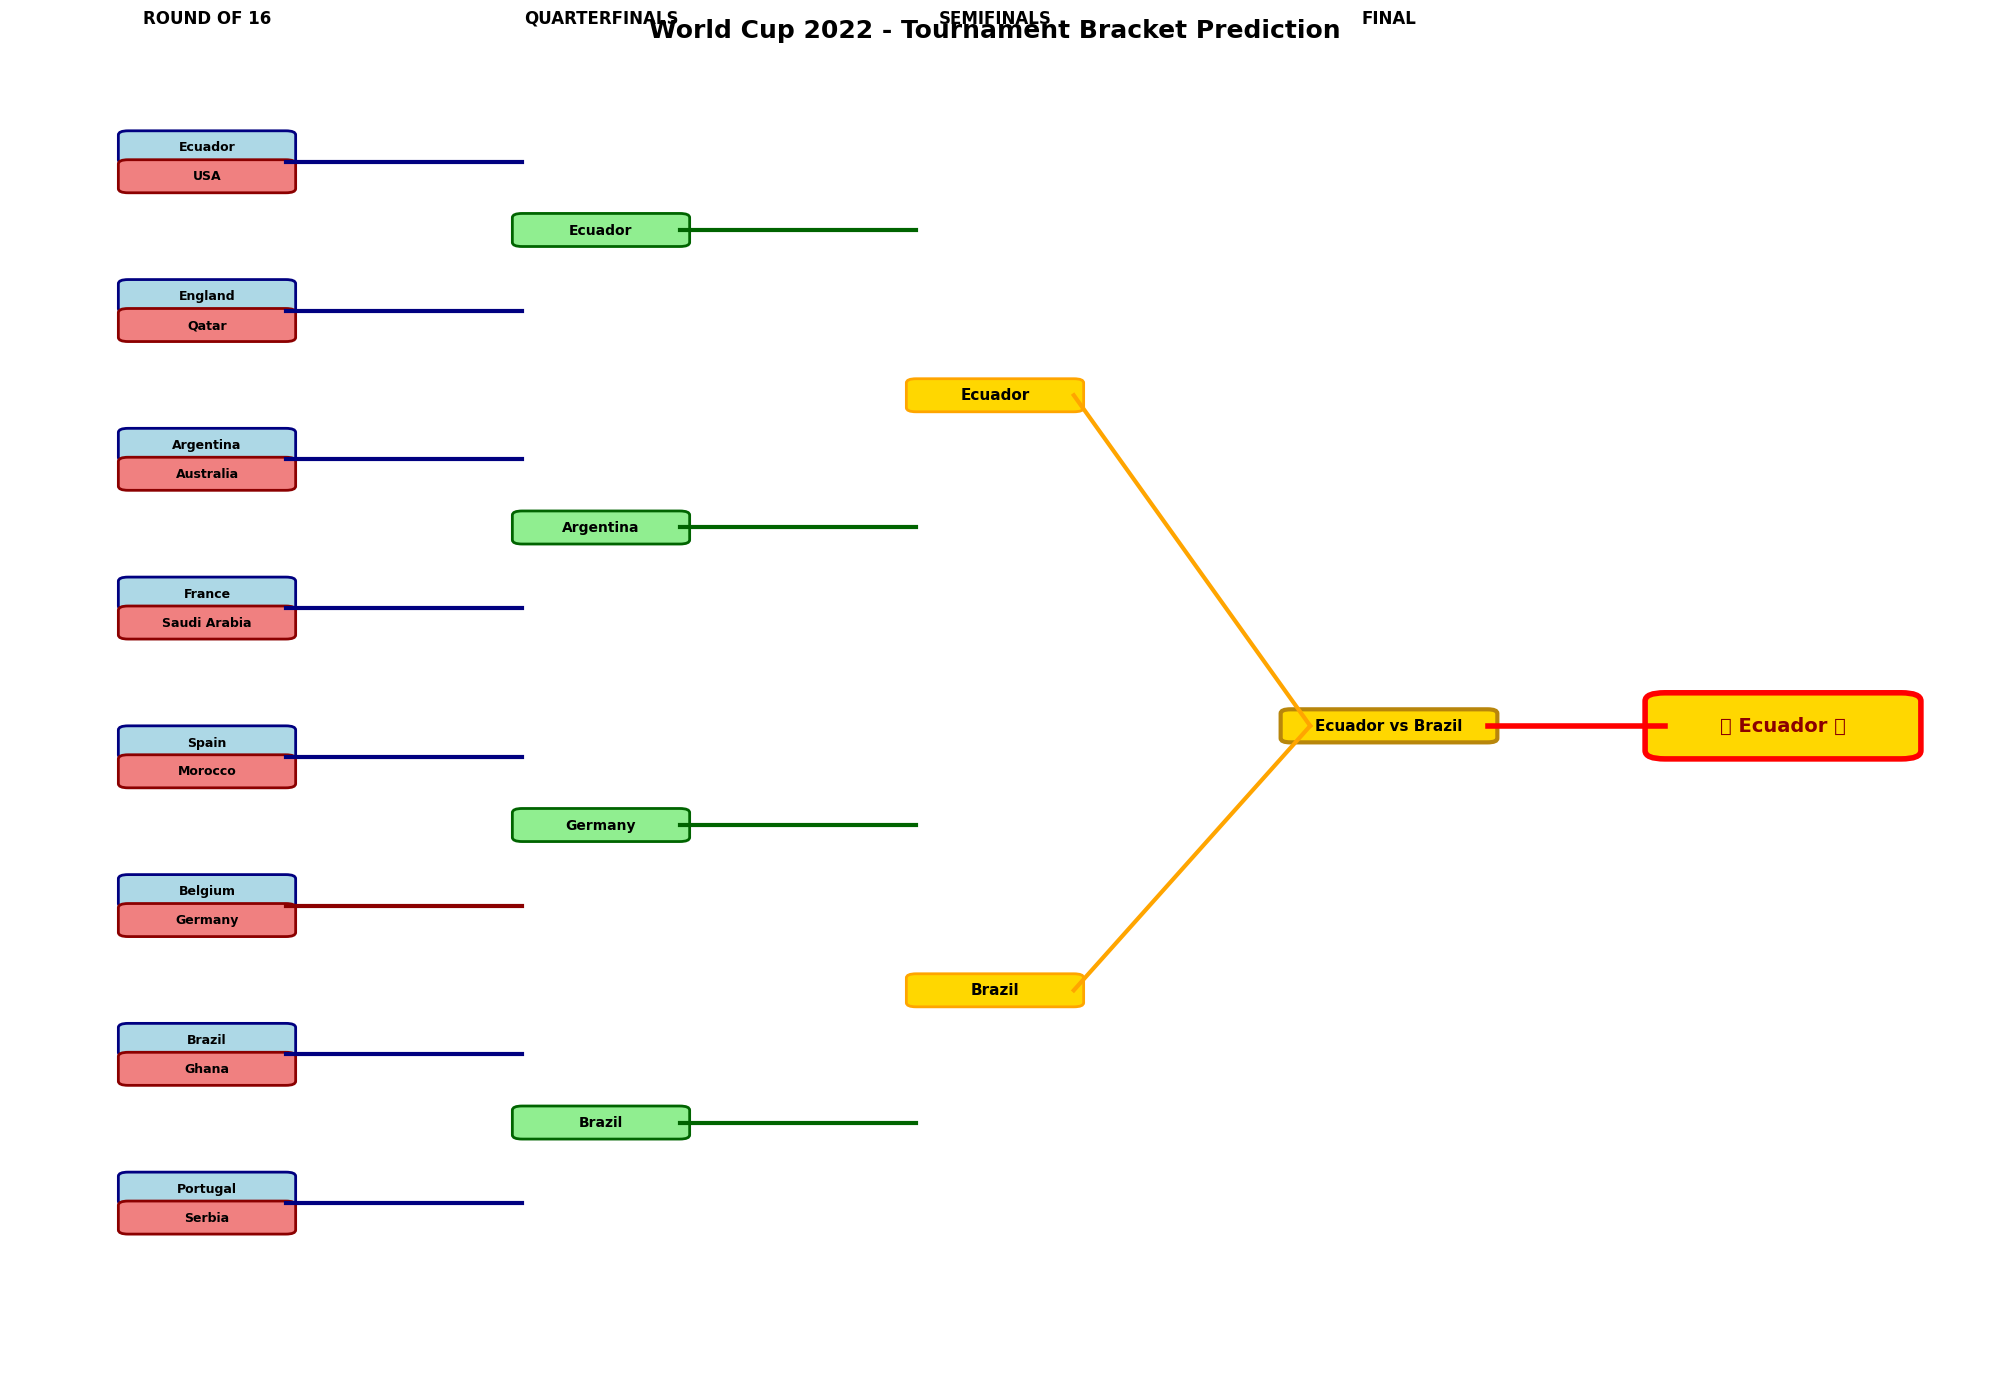

In [ ]:
# Visualisation
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyBboxPatch
import seaborn as sns

fig, ax = plt.subplots(figsize=(20, 14))
ax.set_xlim(0, 10)
ax.set_ylim(0, 16)
ax.axis('off')

# Define positions for each round
rounds = {
    'R16': 1,
    'QF': 3,
    'SF': 5,
    'F': 7,
    'Winner': 9
}

# Round of 16
y_start = 15
for i, (idx, row) in enumerate(knockout_df.iterrows()):
    y = y_start - i*1.8
    # Home team
    ax.add_patch(FancyBboxPatch((rounds['R16']-0.4, y-0.15), 0.8, 0.3,
                                boxstyle="round,pad=0.05",
                                facecolor='lightblue', edgecolor='navy', linewidth=2))
    ax.text(rounds['R16'], y, row['home_team'], ha='center', va='center', fontsize=9, weight='bold')

    # Away team
    ax.add_patch(FancyBboxPatch((rounds['R16']-0.4, y-0.5), 0.8, 0.3,
                                boxstyle="round,pad=0.05",
                                facecolor='lightcoral', edgecolor='darkred', linewidth=2))
    ax.text(rounds['R16'], y-0.35, row['away_team'], ha='center', va='center', fontsize=9, weight='bold')

    # Winner line to QF
    winner_color = 'navy' if r16_winners[i] == row['home_team'] else 'darkred'
    ax.plot([rounds['R16']+0.4, rounds['QF']-0.4], [y-0.175, y-0.175],
            color=winner_color, linewidth=3)

# Quarterfinals
y_start = 14
for i, (idx, row) in enumerate(quarter_df.iterrows()):
    y = y_start - i*3.6
    ax.add_patch(FancyBboxPatch((rounds['QF']-0.4, y-0.15), 0.8, 0.3,
                                boxstyle="round,pad=0.05",
                                facecolor='lightgreen', edgecolor='darkgreen', linewidth=2))
    ax.text(rounds['QF'], y, qf_winners[i], ha='center', va='center', fontsize=10, weight='bold')
    ax.plot([rounds['QF']+0.4, rounds['SF']-0.4], [y, y],
            color='darkgreen', linewidth=3)

# Semifinals
y_start = 12
for i, (idx, row) in enumerate(semi_df.iterrows()):
    y = y_start - i*7.2
    ax.add_patch(FancyBboxPatch((rounds['SF']-0.4, y-0.15), 0.8, 0.3,
                                boxstyle="round,pad=0.05",
                                facecolor='gold', edgecolor='orange', linewidth=2))
    ax.text(rounds['SF'], y, sf_winners[i], ha='center', va='center', fontsize=11, weight='bold')
    ax.plot([rounds['SF']+0.4, rounds['F']-0.4], [y, 8],
            color='orange', linewidth=3)

# Final
ax.add_patch(FancyBboxPatch((rounds['F']-0.5, 7.85), 1.0, 0.3,
                            boxstyle="round,pad=0.05",
                            facecolor='gold', edgecolor='darkgoldenrod', linewidth=3))
ax.text(rounds['F'], 8, f"{sf_winners[0]} vs {sf_winners[1]}",
        ha='center', va='center', fontsize=11, weight='bold')

# Champion
ax.add_patch(FancyBboxPatch((rounds['Winner']-0.6, 7.7), 1.2, 0.6,
                            boxstyle="round,pad=0.1",
                            facecolor='gold', edgecolor='red', linewidth=4))
ax.text(rounds['Winner'], 8, f"🏆 {champion} 🏆",
        ha='center', va='center', fontsize=14, weight='bold', color='darkred')
ax.plot([rounds['F']+0.5, rounds['Winner']-0.6], [8, 8],
        color='red', linewidth=4)

# Add round labels
ax.text(rounds['R16'], 16.5, 'ROUND OF 16', ha='center', fontsize=12, weight='bold')
ax.text(rounds['QF'], 16.5, 'QUARTERFINALS', ha='center', fontsize=12, weight='bold')
ax.text(rounds['SF'], 16.5, 'SEMIFINALS', ha='center', fontsize=12, weight='bold')
ax.text(rounds['F'], 16.5, 'FINAL', ha='center', fontsize=12, weight='bold')

plt.title('World Cup 2022 - Tournament Bracket Prediction', fontsize=18, weight='bold', pad=20)
plt.tight_layout()
plt.show()

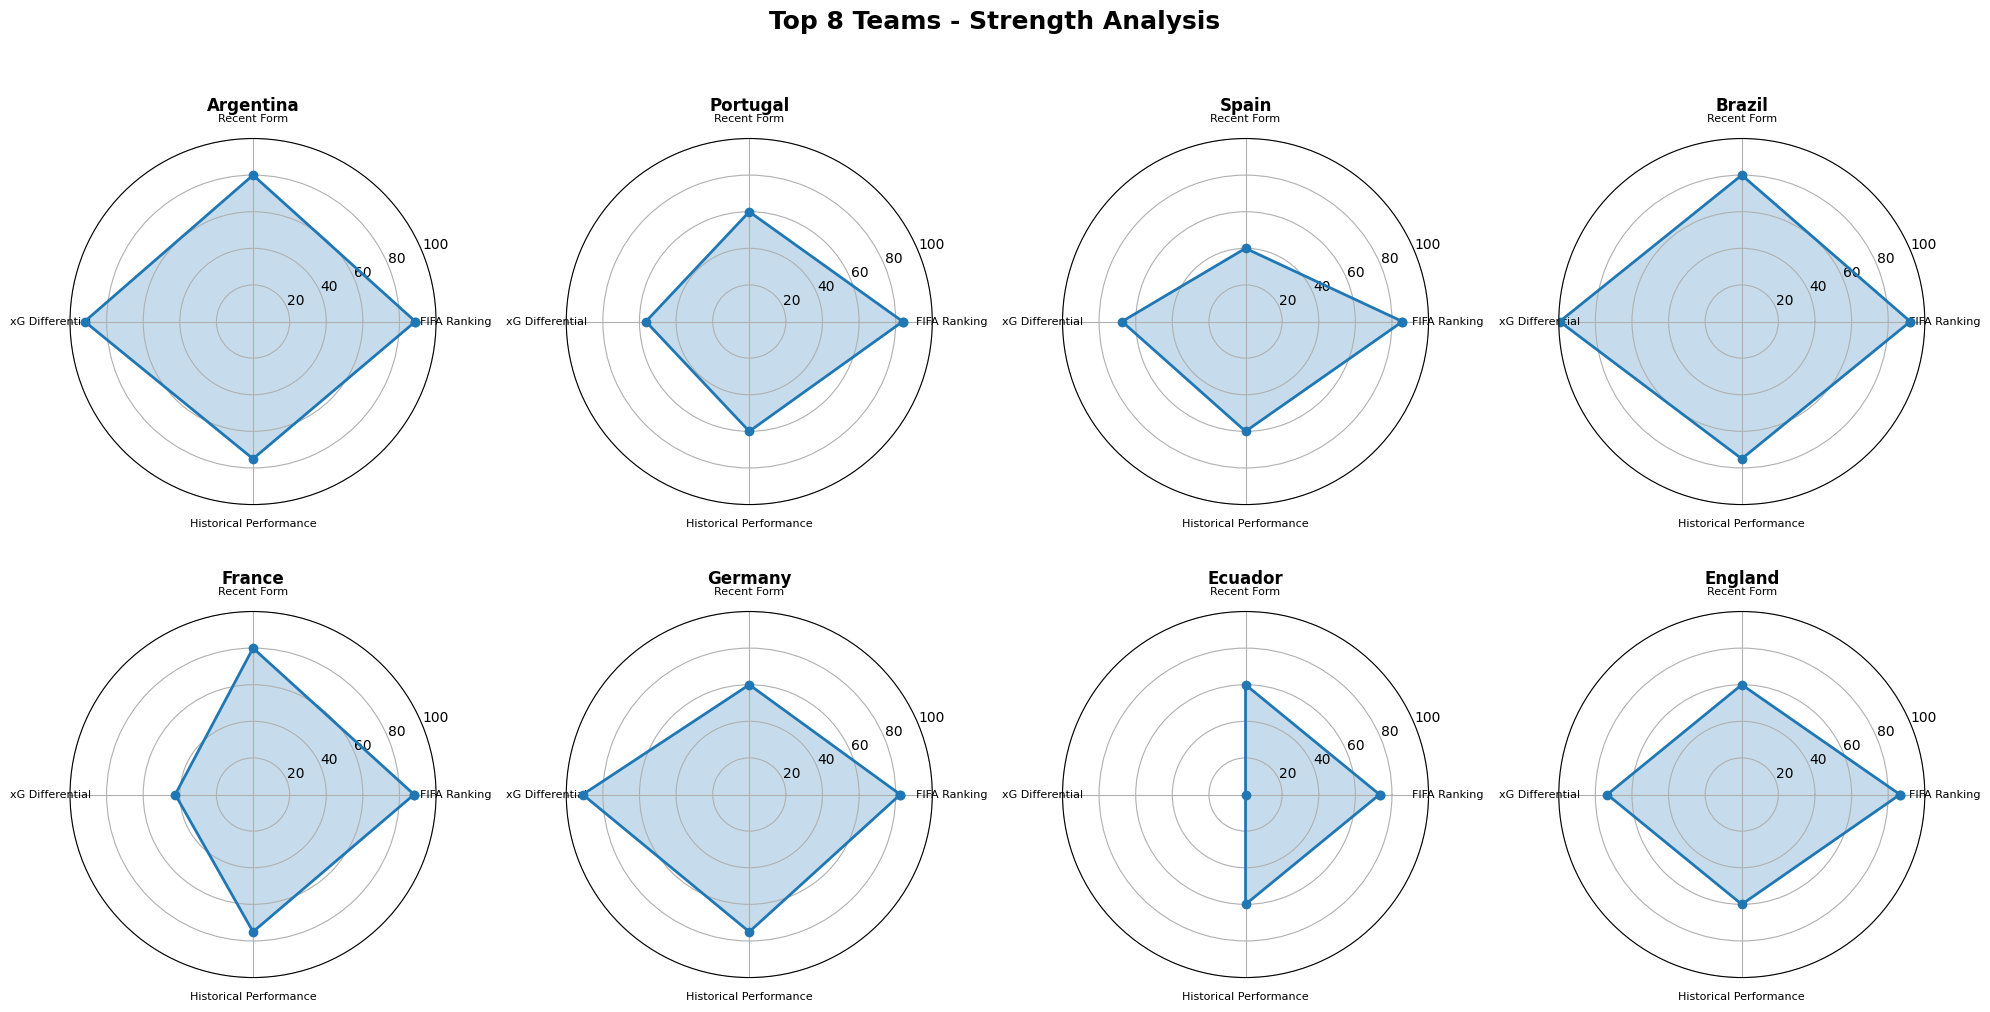

In [ ]:
from math import pi

# Get top 8 teams by FIFA ranking
top_teams = []
for winners_list in [r16_winners, qf_winners, sf_winners, [champion]]:
    top_teams.extend(winners_list)
top_teams = list(set(top_teams))[:8]

# Create radar chart
categories = ['FIFA Ranking', 'Recent Form', 'xG Differential', 'Historical Performance']
fig, axes = plt.subplots(2, 4, figsize=(20, 10), subplot_kw=dict(projection='polar'))
axes = axes.flatten()

for idx, team in enumerate(top_teams[:8]):
    # Get team stats
    team_stats = fifa_rankings_clean[fifa_rankings_clean['team']==team]

    if len(team_stats) > 0:
        fifa_score = team_stats['ranking_points'].values[0] / 2000 * 100
    else:
        fifa_score = 50

    form_score = np.mean(team_form[team][-5:])*100 if team in team_form and len(team_form[team]) > 0 else 50
    xg_score = min(100, max(0, (np.mean(team_xg_diff[team][-5:]) + 2) / 4 * 100)) if team in team_xg_diff and len(team_xg_diff[team]) > 0 else 50
    hist_score = 75 if team in ['Brazil', 'Germany', 'Argentina', 'France', 'Italy'] else 60

    values = [fifa_score, form_score, xg_score, hist_score]

    # Number of variables
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    values += values[:1]
    angles += angles[:1]

    ax = axes[idx]
    ax.plot(angles, values, 'o-', linewidth=2, label=team)
    ax.fill(angles, values, alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, size=8)
    ax.set_ylim(0, 100)
    ax.set_title(team, size=12, weight='bold', pad=20)
    ax.grid(True)

plt.suptitle('Top 8 Teams - Strength Analysis', fontsize=18, weight='bold', y=1.02)
plt.tight_layout()
plt.show()

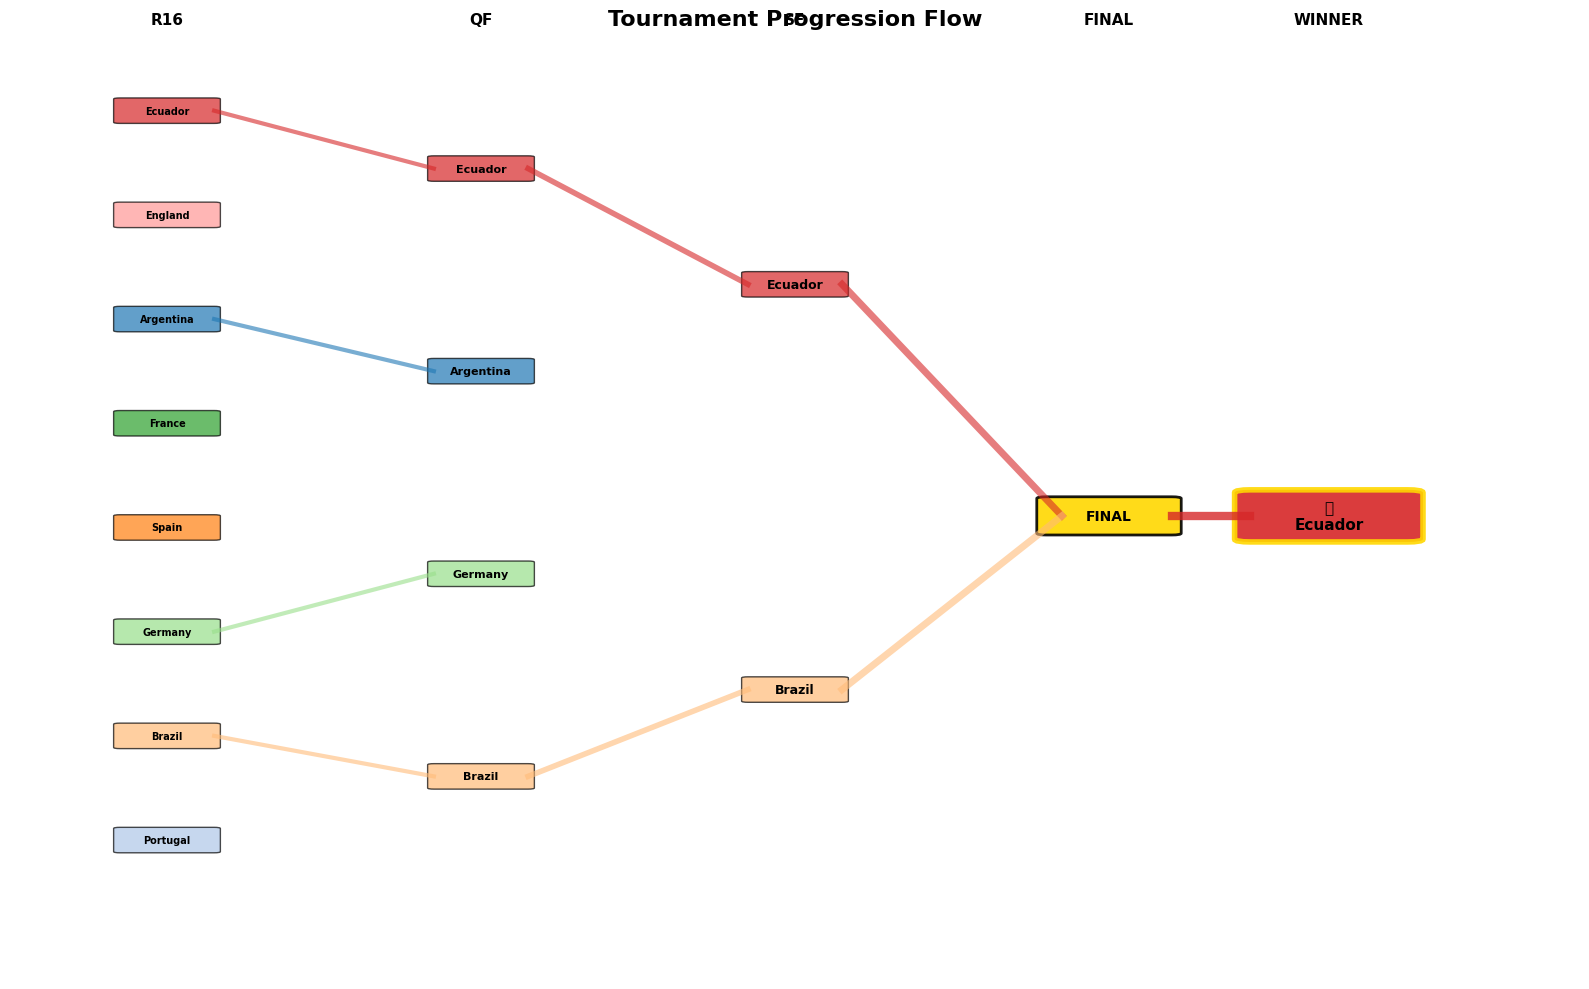

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyBboxPatch
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(16, 10))
ax.set_xlim(0, 5)
ax.set_ylim(0, 16)
ax.axis('off')

# Define stages
stages = ['R16', 'QF', 'SF', 'F', 'Winner']
x_positions = [0.5, 1.5, 2.5, 3.5, 4.2]

# Color map for teams
colors = plt.cm.tab20(np.linspace(0, 1, 20))
team_colors = {team: colors[i % 20] for i, team in enumerate(set(r16_winners))}

# Round of 16 to QF
y_pos = 15
for i, team in enumerate(r16_winners):
    ax.add_patch(FancyBboxPatch((x_positions[0]-0.15, y_pos-0.2), 0.3, 0.4,
                                boxstyle="round,pad=0.02",
                                facecolor=team_colors[team], alpha=0.7, edgecolor='black'))
    ax.text(x_positions[0], y_pos, team, ha='center', va='center', fontsize=7, weight='bold')

    # Line to QF
    qf_idx = qf_winners.index(team) if team in qf_winners else -1
    if qf_idx >= 0:
        qf_y = 14 - qf_idx * 3.5
        ax.plot([x_positions[0]+0.15, x_positions[1]-0.15], [y_pos, qf_y],
                color=team_colors[team], alpha=0.6, linewidth=3)

    y_pos -= 1.8

# Quarterfinals
y_pos = 14
for i, team in enumerate(qf_winners):
    ax.add_patch(FancyBboxPatch((x_positions[1]-0.15, y_pos-0.2), 0.3, 0.4,
                                boxstyle="round,pad=0.02",
                                facecolor=team_colors[team], alpha=0.7, edgecolor='black'))
    ax.text(x_positions[1], y_pos, team, ha='center', va='center', fontsize=8, weight='bold')

    # Line to SF
    sf_idx = sf_winners.index(team) if team in sf_winners else -1
    if sf_idx >= 0:
        sf_y = 12 - sf_idx * 7
        ax.plot([x_positions[1]+0.15, x_positions[2]-0.15], [y_pos, sf_y],
                color=team_colors[team], alpha=0.6, linewidth=4)

    y_pos -= 3.5

# Semifinals
y_pos = 12
for i, team in enumerate(sf_winners):
    ax.add_patch(FancyBboxPatch((x_positions[2]-0.15, y_pos-0.2), 0.3, 0.4,
                                boxstyle="round,pad=0.02",
                                facecolor=team_colors[team], alpha=0.7, edgecolor='black'))
    ax.text(x_positions[2], y_pos, team, ha='center', va='center', fontsize=9, weight='bold')

    # Line to Final
    ax.plot([x_positions[2]+0.15, x_positions[3]-0.15], [y_pos, 8],
            color=team_colors[team], alpha=0.6, linewidth=5)

    y_pos -= 7

# Final
ax.add_patch(FancyBboxPatch((x_positions[3]-0.2, 7.7), 0.4, 0.6,
                            boxstyle="round,pad=0.03",
                            facecolor='gold', alpha=0.9, edgecolor='black', linewidth=2))
ax.text(x_positions[3], 8, 'FINAL', ha='center', va='center', fontsize=10, weight='bold')

# Champion
ax.add_patch(FancyBboxPatch((x_positions[4]-0.25, 7.6), 0.5, 0.8,
                            boxstyle="round,pad=0.05",
                            facecolor=team_colors[champion], alpha=0.9,
                            edgecolor='gold', linewidth=4))
ax.text(x_positions[4], 8, f"🏆\n{champion}", ha='center', va='center',
        fontsize=11, weight='bold')
ax.plot([x_positions[3]+0.2, x_positions[4]-0.25], [8, 8],
        color=team_colors[champion], alpha=0.8, linewidth=6)

# Stage labels
for i, stage in enumerate(['R16', 'QF', 'SF', 'FINAL', 'WINNER']):
    ax.text(x_positions[i], 16.5, stage, ha='center', fontsize=11, weight='bold')

plt.title('Tournament Progression Flow', fontsize=16, weight='bold', pad=20)
plt.tight_layout()
plt.show()